<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/Lab_10_2D_Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Convolutional Neural Networks

In this lab, we will train two models:

1. A traditional VGG16 model, where we will train the last couple of layers to adapt it to our problem.

2. A more humble model that we design here.

The problem is to predict one of 6 categories of pictures, whether they are. 'buildings', 'forest', 'glacier', 'mountain', 'sea' or 'street'

First, we load the data.

In [1]:
!gdown 'https://drive.google.com/uc?export=download&id=1HEB7JHl6uSANiENvaHBxhzmkkZ9YlhEC'

Downloading...
From: https://drive.google.com/uc?export=download&id=1HEB7JHl6uSANiENvaHBxhzmkkZ9YlhEC
To: /content/IntelClassification.zip
255MB [00:01, 218MB/s]


In [2]:
!unzip IntelClassification.zip

Archive:  IntelClassification.zip
   creating: IntelClassification/
   creating: IntelClassification/seg_test/
   creating: IntelClassification/seg_test/buildings/
  inflating: IntelClassification/seg_test/buildings/20057.jpg  
  inflating: IntelClassification/seg_test/buildings/20060.jpg  
  inflating: IntelClassification/seg_test/buildings/20061.jpg  
  inflating: IntelClassification/seg_test/buildings/20064.jpg  
  inflating: IntelClassification/seg_test/buildings/20073.jpg  
  inflating: IntelClassification/seg_test/buildings/20074.jpg  
  inflating: IntelClassification/seg_test/buildings/20078.jpg  
  inflating: IntelClassification/seg_test/buildings/20083.jpg  
  inflating: IntelClassification/seg_test/buildings/20094.jpg  
  inflating: IntelClassification/seg_test/buildings/20096.jpg  
  inflating: IntelClassification/seg_test/buildings/20113.jpg  
  inflating: IntelClassification/seg_test/buildings/20131.jpg  
  inflating: IntelClassification/seg_test/buildings/20140.jpg  
  in

## VGG16

The VGG 16 model is a classic model in Deep Learning. It is a 16 layer model, following the structure that we discussed in the lectures.

This model was trained over the ImageNet data, thus looking to classify among 1000 different types of objects, over a very large database of images. We can leverage these already-trained weights, and  adapt just the last few layers for our purposes.

We start by loading the VGG16 model. Keras comes pre-packaged with a series of models, loaded into the [Applications library](https://keras.io/applications/). We start by first loading the model on-the-fly using the library. We can check the options of the model in the options of the fuction [VGG16](https://keras.io/applications/#vgg16).

We also need a package that allows for an efficient storage of the model using a binary format. The package is called [h5py](https://www.h5py.org/) and also allows for storing your pre-trained models. You can read a tutorial for this [here](https://machinelearningmastery.com/save-load-keras-deep-learning-models/).

In [0]:
import numpy as np
import h5py as h5py
import PIL
# Others
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc


# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights = 'imagenet',    # The weights from the ImageNet competition
              include_top = False,     # Do not include the top layer, which classifies.
              input_shape= (224, 224, 3) # Input shape. Three channels, and BGR (NOT RGB!!!)
             )

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


This will download the model and save it to our unoriginally named variable model. It is a pretty beefy download, at around 500MB. Luckly we have fast internet in the lab :)

We can now check the details of the model as usual.

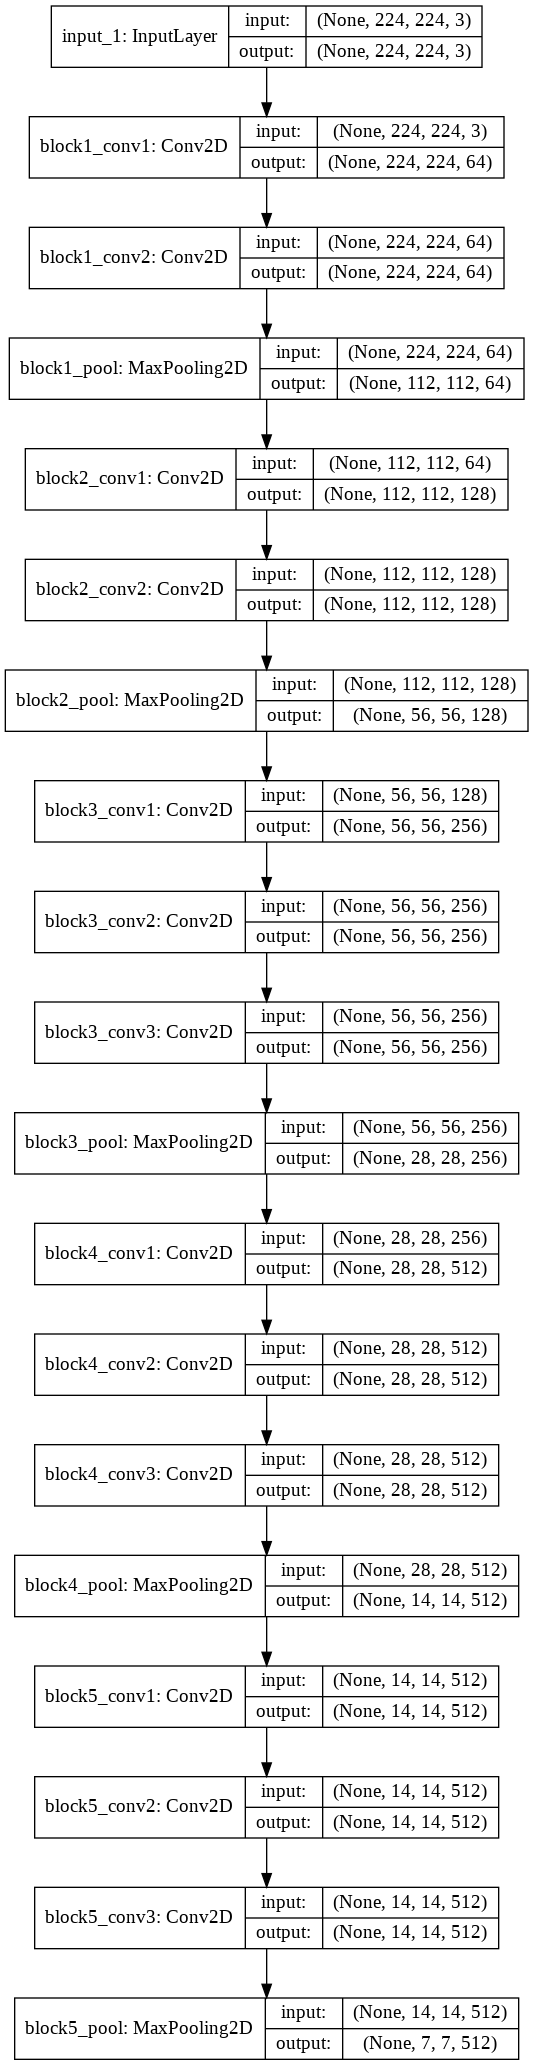

In [5]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='GraphModel.png')
Image(retina=True, filename='GraphModel.png')

At this point, every single parameter is trainable. We don't need this, as we want to use the parameters that come with the model. We will create a parallel model to store the new trainable layers, and then set all of these layers as untrainable. We will finally add a Dense layer with 128 neurons, plus a Dense layer with two classes.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

In [0]:
# Create new model
CBModel = Sequential()

# Copy the layers to our new model. This needs to be done as there is a bug in Keras.
for layer in model.layers:
    CBModel.add(layer)

# Set the layers as untrainable
for layer in CBModel.layers:
    layer.trainable = False

In [8]:
CBModel.add(Flatten(input_shape=model.output_shape[1:]))
CBModel.add(Dense(64, activation = 'relu'))
CBModel.add(Dropout(0.5))
CBModel.add(Dense(6, activation = 'softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
CBModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [0]:
CBModel.compile(loss='categorical_crossentropy', # This is NOT a binary problem!
              optimizer=optimizers.adam(),
              metrics=['accuracy'])

Ready! We can now load the data. We have our set of pictures ready for this example.

We will first build two image generators (one for testing and one for training), which will generate new samples on the fly using our pictures as input. This is the same that we say in the lectures.

In [13]:
# prepare data augmentation configuration
datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

# We will use a batch size of 32. Depends on RAM of GPU.
batch_size = 32

# Train data generator. We point to the training directory!
train_data_dir = 'IntelClassification/seg_train'

# VGG requires 224 x 224 images.
(img_height, img_width) = (224, 224)

train_generator = datagen.flow_from_directory(
    train_data_dir, # Where are the pics
    target_size=(img_height, img_width), # What size should they be
    batch_size=batch_size, # Size of batch
    class_mode='categorical' # Class mode, whether 'binary' or 'categorical'
)

# Validation data generator.
validation_data_dir = 'IntelClassification/seg_test'
validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Now the system is ready to train from the images that we have loaded. We now feed the generators to the model, and ask to train for a certain number of epochs.

In [14]:
# Number of epochs
epochs = 20

# Train!
CBModel.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch = 32, # Usually cases / batch_size. Reduced to 32 so it runs faster.
    validation_steps = 32 # Number of validation steps.
)

Epoch 1/10
32/32 [==============================] - 26s 823ms/step - loss: 1.5627 - acc: 0.3232 - val_loss: 1.2125 - val_acc: 0.5342
Epoch 2/10
32/32 [==============================] - 20s 637ms/step - loss: 1.3058 - acc: 0.4658 - val_loss: 1.0355 - val_acc: 0.5811
Epoch 3/10
32/32 [==============================] - 21s 658ms/step - loss: 1.2224 - acc: 0.4521 - val_loss: 1.0148 - val_acc: 0.5551
Epoch 4/10
32/32 [==============================] - 18s 578ms/step - loss: 1.2016 - acc: 0.4678 - val_loss: 0.9552 - val_acc: 0.5879
Epoch 5/10
32/32 [==============================] - 20s 628ms/step - loss: 1.1297 - acc: 0.4873 - val_loss: 0.8991 - val_acc: 0.6357
Epoch 6/10
32/32 [==============================] - 20s 627ms/step - loss: 1.0936 - acc: 0.4824 - val_loss: 0.7750 - val_acc: 0.6644
Epoch 7/10
32/32 [==============================] - 19s 595ms/step - loss: 1.0220 - acc: 0.5234 - val_loss: 0.8074 - val_acc: 0.6758
Epoch 8/10
32/32 [==============================] - 19s 595ms/step - 

The model is able to learn quite well! Let's check the convergence plot.

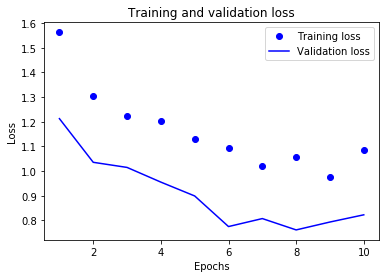

In [15]:
loss = CBModel.history.history['loss']
val_loss = CBModel.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Training of simple(r) network.

Let's try a simpler architecture. A sequence of three Separable Convlutions, of 64 filters, followed  by a batch normalization layer. We will then add a max_pooling of 3x3 and our common dense layer with a softmax output.

Note: Keras does not yet have BatchRenormalization implemented. It has been announced that it will be included later. For now, you can use the proposed implementation available [here](https://github.com/titu1994/BatchRenormalization).

In [0]:
from keras.layers import SeparableConv2D, BatchNormalization, Input, MaxPooling2D

In [0]:
SimpleModel = Sequential()

# Our blocks
SimpleModel.add(SeparableConv2D(filters=64, kernel_size=(2, 2), input_shape = (224, 224, 3),
                               activation = 'relu'))
SimpleModel.add(BatchNormalization())

SimpleModel.add(SeparableConv2D(filters=64, kernel_size=(2, 2), activation = 'relu'))
SimpleModel.add(BatchNormalization())

SimpleModel.add(SeparableConv2D(filters=64, kernel_size=(2, 2), activation = 'relu'))
SimpleModel.add(BatchNormalization())

SimpleModel.add(MaxPooling2D(pool_size = (3, 3)))

# Second group. More filters per layer.
SimpleModel.add(SeparableConv2D(filters=128, kernel_size=(2, 2), activation = 'relu'))
SimpleModel.add(BatchNormalization())

SimpleModel.add(SeparableConv2D(filters=128, kernel_size=(2, 2), activation = 'relu'))
SimpleModel.add(BatchNormalization())

SimpleModel.add(SeparableConv2D(filters=128, kernel_size=(2, 2), activation = 'relu'))
SimpleModel.add(BatchNormalization())

SimpleModel.add(MaxPooling2D(pool_size = (3, 3)))

# Third group. More filters per layer.
SimpleModel.add(SeparableConv2D(filters=256, kernel_size=(2, 2), activation = 'relu'))
SimpleModel.add(BatchNormalization())

SimpleModel.add(SeparableConv2D(filters=256, kernel_size=(2, 2), activation = 'relu'))
SimpleModel.add(BatchNormalization())

SimpleModel.add(SeparableConv2D(filters=256, kernel_size=(2, 2), activation = 'relu'))
SimpleModel.add(BatchNormalization())

SimpleModel.add(MaxPooling2D(pool_size = (3, 3)))

# The prediction layers
SimpleModel.add(Flatten())
SimpleModel.add(Dense(128, activation = 'relu'))
SimpleModel.add(Dropout(0.5))
SimpleModel.add(Dense(128, activation = 'relu'))
SimpleModel.add(Dropout(0.5))
SimpleModel.add(Dense(6, activation = 'softmax')) # Softmax, not sigmoid!

In [43]:
SimpleModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_25 (Separab (None, 223, 223, 64)      268       
_________________________________________________________________
batch_normalization_25 (Batc (None, 223, 223, 64)      256       
_________________________________________________________________
separable_conv2d_26 (Separab (None, 222, 222, 64)      4416      
_________________________________________________________________
batch_normalization_26 (Batc (None, 222, 222, 64)      256       
_________________________________________________________________
separable_conv2d_27 (Separab (None, 221, 221, 64)      4416      
_________________________________________________________________
batch_normalization_27 (Batc (None, 221, 221, 64)      256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 73, 73, 64)        0         
__________

We now train using the same generators as before.

In [0]:
SimpleModel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam(),
              metrics=['accuracy'])

In [45]:
SimpleModel.fit_generator(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    steps_per_epoch = 32, # Generate 3 batches
    validation_steps = 32
)

Epoch 1/20
3/3 [==============================] - 12s 4s/step - loss: 5.9354 - acc: 0.2188 - val_loss: 4.9354 - val_acc: 0.1979
Epoch 2/20
3/3 [==============================] - 3s 930ms/step - loss: 8.0353 - acc: 0.2188 - val_loss: 4.5573 - val_acc: 0.1771
Epoch 3/20
3/3 [==============================] - 3s 903ms/step - loss: 6.3725 - acc: 0.1875 - val_loss: 2.8570 - val_acc: 0.3021
Epoch 4/20
3/3 [==============================] - 3s 892ms/step - loss: 4.4713 - acc: 0.1979 - val_loss: 2.1360 - val_acc: 0.3229
Epoch 5/20
3/3 [==============================] - 3s 913ms/step - loss: 3.6984 - acc: 0.2188 - val_loss: 2.2130 - val_acc: 0.3229
Epoch 6/20
3/3 [==============================] - 3s 876ms/step - loss: 2.4362 - acc: 0.2812 - val_loss: 2.1574 - val_acc: 0.3125
Epoch 7/20
3/3 [==============================] - 3s 850ms/step - loss: 2.2951 - acc: 0.1979 - val_loss: 2.1107 - val_acc: 0.2604
Epoch 8/20
3/3 [==============================] - 3s 930ms/step - loss: 2.1513 - acc: 0.2396

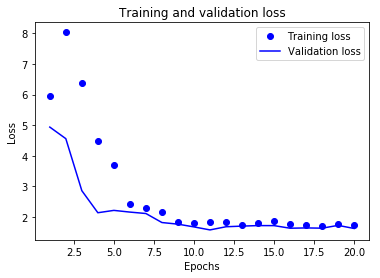

In [46]:
loss = SimpleModel.history.history['loss']
val_loss = SimpleModel.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This model is doing something, but it probably needs more complexity for it to be able to learn efficiently the weights. Or maybe we need to give it more epochs for it to converge correctly!

As self-study, experiment with these configurations, train for longer, and try to get a model that can learn correctly.

## Visualizing learning

As a final example. We will visualize the learning, to detect exactly what is happening.

We start by importing a single image from the pos folder.

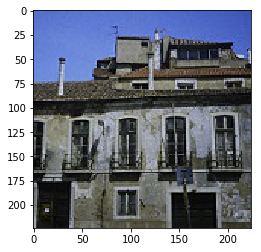

In [47]:
from keras.preprocessing import image
import numpy as np
img_path = 'IntelClassification/seg_test/buildings/24120.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.


plt.imshow(img_tensor[0])
plt.show()

We will now create a model that will have only the activations from the first layer.

In [0]:
from keras import models

# Get output from layer 1.
layer_outputs = CBModel.layers[1].get_output_at(1)

# Create a very simple model that only 
activation_model = models.Model(inputs=CBModel.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

# get the activations
first_layer_activation = activations[0]

In [49]:
first_layer_activation.shape

(224, 224, 64)

The shape is a picture, of size 224 x 224, with 64 filters. We can now visualize any of these, for example, number 4.


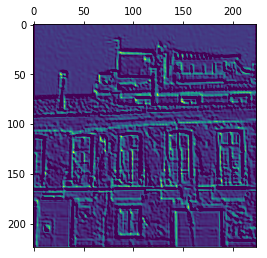

In [50]:
plt.matshow(first_layer_activation[:, :, 5], cmap='viridis')

Let's now try to overlay exactly what is being used to detect people. I will first calculate the probability that is being used.

In [52]:
preds = [1, 0, 0, 0, 0, 0] - CBModel.predict(img_tensor)
CB_output = CBModel.output
preds

array([[ 1.27634525e-01, -8.46654177e-04, -4.09513712e-04,
        -4.94718552e-06, -1.60204618e-05, -9.77067828e-01]])

Now we will extract the final layer, and run a gradient ascent algorithm: Basically we will look for the direction that the model used to get to its decisions. This requires to do some iterations that we won't explain in detail. Please refer to chapter 5.4 of Chollet's book to check the details.

In [0]:
import keras.backend as K

# Import the last layer. We use the name from the model summary.
last_conv_layer = CBModel.get_layer('block5_conv3')

# Get the gradients
grads = K.gradients(CB_output, last_conv_layer.get_output_at(1))[0]

# Pool them using the average (across all filters and dimensions)
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Create a function that will iterate over the results.
iterate = K.function([CBModel.input],
[pooled_grads, last_conv_layer.get_output_at(0)[0]])

Now we will iterate over the results. This looks for "what exactly is activating the network"?

In [0]:
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

This gives the gradients, and the corresponding output, i.e. what part of the network is being activated when. We finally multiply the gradient times the values, and create a heatmap out of this.

In [0]:
# Calculate impact. We run this twice to get to a smoother heatmap.
for j in range(2):
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]



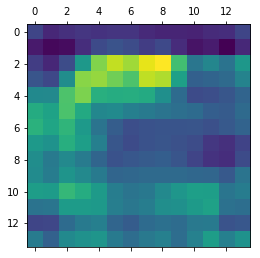

In [70]:
# Create heatmap.
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Plot it.
plt.matshow(heatmap)

Now we will overlay this map over the original picture. We will use the OpenCV package which allows for image manipulation.

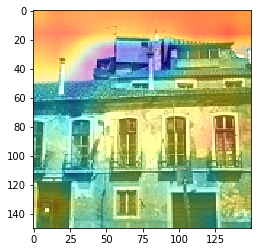

In [71]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 1, heatmap, 0.4, 0)
cv2.imwrite('CBVisualized.jpg', superimposed_img)

plt.imshow(superimposed_img)
plt.show()

Now we can clearly see what is happening. 

This is the importance of the modelling procedures: We need to understand how much diversity we are including in our images: If we don't we might end up learning other things!

Try to change the filters and learning other characteristics.